# Week 1 Seminar

A/B experiment analysis

In [1]:
import glob
from collections import namedtuple

import pandas as pd
import numpy as np
import scipy.stats as ss

import matplotlib.pyplot as plt

pd.set_option("display.precision", 3)

%matplotlib inline

In [2]:
experiment = "DLRM"

In [15]:
data = pd.concat([
    pd.read_json(data_path, lines=True)
    for data_path
    in glob.glob("../../data4exp_dlrm_neg_sampling_demo/*/data.json")
])

data["treatment"] = data["experiments"].map(lambda experiments: experiments[experiment])

In [16]:
data

,message,timestamp,user,track,time,latency,recommendation,experiments,treatment
0,next,2025-04-16 17:19:34.386,8923,27954,1.00,1.080e-03,21394.0,{'DLRM': 'C'},C
1,next,2025-04-16 17:19:34.388,351,45030,1.00,9.086e-04,47092.0,{'DLRM': 'C'},C
2,next,2025-04-16 17:19:34.391,8074,16804,0.02,6.711e-04,23921.0,{'DLRM': 'T1'},T1
3,next,2025-04-16 17:19:34.393,351,47092,0.80,7.379e-04,47092.0,{'DLRM': 'C'},C
4,next,2025-04-16 17:19:34.394,8074,23921,0.00,5.438e-04,1195.0,{'DLRM': 'T1'},T1
...,...,...,...,...,...,...,...,...,...
14877,next,2025-04-16 17:19:43.802,9052,15322,1.00,2.069e-04,20405.0,{'DLRM': 'T1'},T1
14878,next,2025-04-16 17:19:43.805,9052,26613,0.67,2.317e-04,27708.0,{'DLRM': 'T1'},T1
14879,next,2025-04-16 17:19:43.807,9052,35614,0.42,1.726e-04,42473.0,{'DLRM': 'T1'},T1
14880,next,2025-04-16 17:19:43.809,9052,11586,0.09,1.960e-04,21880.0,{'DLRM': 'T1'},T1


In [17]:
data.groupby("treatment").count()

,message,timestamp,user,track,time,latency,recommendation,experiments
treatment,,,,,,,,
C,15656,15656,15656,15656,15656,15656,13681,15656
T1,14108,14108,14108,14108,14108,14108,12083,14108


## Visualize sessions

In [18]:
Session = namedtuple("Session", ["timestamp", "tracks", "time", "latency"])

def sessionize(user_data):
    sessions = []
    session = None
    for _, row in user_data.sort_values("timestamp").iterrows():
        if session is None:
            session = Session(row["timestamp"], 0, 0, 0)
        
        session = session._replace(
            tracks = session.tracks + 1, 
            time = session.time + row["time"],
            latency = session.latency + row["latency"] * 1000,
        )
        
        if row["message"] == "last":
            sessions.append(session._asdict())
            session = None
    return sessions

In [19]:
sessions = (
    data
    .groupby(["user", "treatment"])
    .apply(sessionize)
    .explode()
    .apply(pd.Series)
)

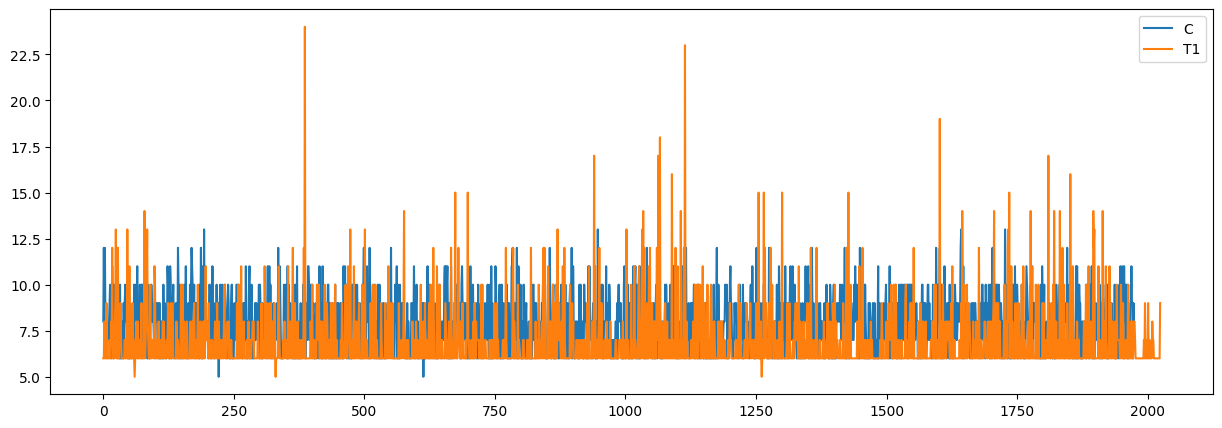

In [20]:
figure, ax = plt.subplots(figsize=(15, 5))
for treatment, treatment_sessions in sessions.groupby("treatment"):
    reindexed_treatment_sessions = treatment_sessions.sort_values("timestamp").reset_index()
    ax.plot(reindexed_treatment_sessions.index, reindexed_treatment_sessions["tracks"], label=treatment)
ax.legend()
pass

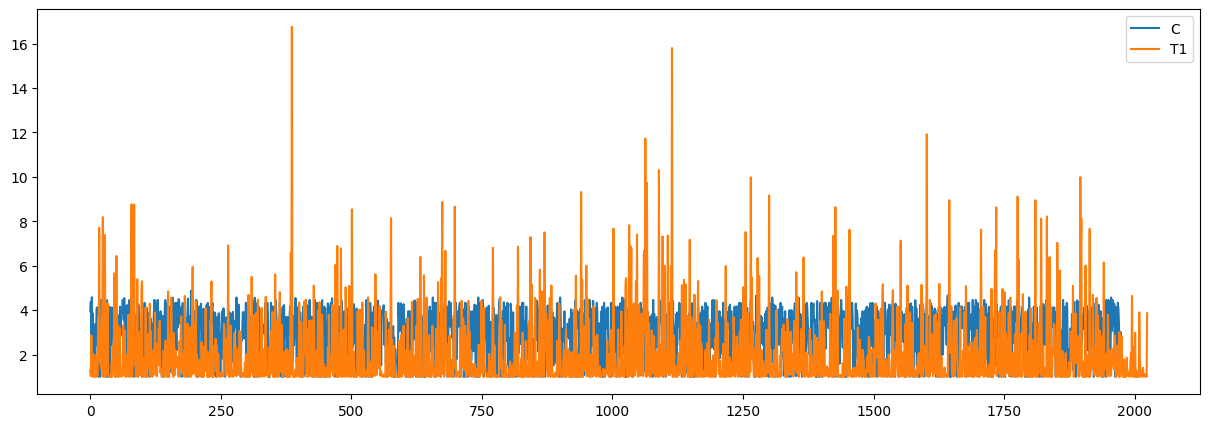

In [21]:
figure, ax = plt.subplots(figsize=(15, 5))
for treatment, treatment_sessions in sessions.groupby("treatment"):
    reindexed_treatment_sessions = treatment_sessions.sort_values("timestamp").reset_index()
    ax.plot(reindexed_treatment_sessions.index, reindexed_treatment_sessions["time"], label=treatment)
ax.legend()
pass

## Analyze the experiment

In [22]:
user_level_data = (
  sessions
    .reset_index()
    .groupby(["user", "treatment"])
    .agg(
        {
            "timestamp": "count",
            "tracks": "sum",
            "time": "sum",
            "latency": "sum"
        }
    )
)

user_level_data["sessions"] = user_level_data["timestamp"]
user_level_data["mean_request_latency"] = user_level_data["latency"] / user_level_data["tracks"]
user_level_data["mean_tracks_per_session"] = user_level_data["tracks"] / user_level_data["sessions"]
user_level_data["mean_time_per_session"] = user_level_data["time"] / user_level_data["sessions"]

metrics = [
    "time", 
    "sessions", 
    "mean_request_latency", 
    "mean_tracks_per_session", 
    "mean_time_per_session"
]

user_level_metrics = user_level_data[metrics].copy().reset_index()

In [23]:
treatment_level_metrics = (
    user_level_metrics
    .groupby("treatment")[metrics]
    .agg(["count", "mean", "var"])
)

In [24]:
def dof(n_0, n_1, s2_0, s2_1):
    numerator = (s2_0 / n_0 + s2_1 / n_1) * (s2_0 / n_0 + s2_1 / n_1)
    denominator = s2_0 * s2_0 / n_0 / n_0 / (n_0 - 1) + s2_1 * s2_1 / n_1 / n_1 / (n_1 - 1)
    return numerator / denominator


def ci(n_0, n_1, s2_0, s2_1, alpha=0.05):
    return ss.t.ppf(1 - alpha/2, dof(n_0, n_1, s2_0, s2_1)) * np.sqrt(s2_0 / n_0 + s2_1 / n_1)


effects = []

control = [data for treatment, data in treatment_level_metrics.iterrows() if treatment == "C"][0]

for treatment, row in treatment_level_metrics.iterrows():
    if treatment == "C":
        continue
    
    for metric in metrics:
        control_mean = control[metric]["mean"]
        treatment_mean = row[metric]["mean"]
        
        effect = treatment_mean - control_mean
        conf_int = ci(
            control[metric]["count"],
            row[metric]["count"],
            control[metric]["var"],
            row[metric]["var"],
        )
        effects.append({
            "treatment": treatment,
            "metric": metric,
            "control_mean": control_mean,
            "treatment_mean": treatment_mean,
            "effect": effect / control_mean * 100,
            "lower": (effect - conf_int) / control_mean * 100,
            "upper": (effect + conf_int) / control_mean * 100,
            "significant": (effect + conf_int) * (effect - conf_int) > 0
        })

In [25]:
def color(value):
    return 'color:red;' if value < 0 else 'color:green;'

def background(value):
    return 'color:white;background-color:green' if value else 'color:white;background-color:red'
        

(
    pd.DataFrame(effects)[[
        "treatment", 
        "metric",
        "effect", 
        "upper", 
        "lower", 
        "control_mean", 
        "treatment_mean",
        "significant"
    ]]
    .sort_values(["metric", "treatment"], ascending=False)
    .style
    .applymap(color, subset=["effect", "upper", "lower"])
    .applymap(background, subset=["significant"])
)

,treatment,metric,effect,upper,lower,control_mean,treatment_mean,significant
0,T1,time,-31.464594,-27.557531,-35.371657,3.565219,2.443437,True
1,T1,sessions,3.032411,5.735133,0.329688,1.199878,1.236264,True
3,T1,mean_tracks_per_session,-11.886175,-10.517428,-13.254922,7.905124,6.965507,True
4,T1,mean_time_per_session,-33.041878,-29.986050,-36.097707,2.961541,1.982992,True
2,T1,mean_request_latency,-26.048578,-25.498695,-26.598462,0.223036,0.164938,True
